# Trace metadata visualizer

In [1]:
import numpy as np
import sqlite3 as lite
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import os

from utils.db_utils import get_db_absolute_path

In [2]:
# Setup sqlite connection
database = get_db_absolute_path("main.db")
con = lite.connect(database)

In [3]:
query = "select * from trace_metadata_depth;"
trace_metadata_depth = pd.read_sql_query(query, con)
trace_metadata_depth

,id,test_dataset_id,training_dataset_id,environment_id,distance,device,additive_noise_method_id,trace_process_id,data_point_index,max_val,min_val,mean_val,rms_val,std_val,snr_val
0,1,1.0,NaN,1.0,15.0,6.0,None,2,0,0.008866,0.001883,0.004728,0.004771,0.000637,55.020428
1,2,1.0,NaN,1.0,15.0,6.0,None,2,1,0.009523,0.002287,0.006070,0.006092,0.000518,137.369634
2,3,1.0,NaN,1.0,15.0,6.0,None,2,2,0.008784,0.003245,0.005202,0.005238,0.000610,72.626607
3,4,1.0,NaN,1.0,15.0,6.0,None,2,3,0.011342,0.003219,0.006682,0.006784,0.001176,32.295103
4,5,1.0,NaN,1.0,15.0,6.0,None,2,4,0.010359,0.003787,0.007520,0.007586,0.000995,57.130985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12795,12796,NaN,1.0,NaN,NaN,NaN,None,3,395,0.509004,0.243324,0.442223,0.442282,0.007191,3781.462800
12796,12797,NaN,1.0,NaN,NaN,NaN,None,3,396,0.489343,0.327530,0.427615,0.427677,0.007282,3448.453597
12797,12798,NaN,1.0,NaN,NaN,NaN,None,3,397,0.512282,0.258694,0.436050,0.436113,0.007443,3432.536159
12798,12799,NaN,1.0,NaN,NaN,NaN,None,3,398,0.500843,0.273349,0.435753,0.435811,0.007143,3721.454679


In [4]:
custom_lines = [Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='r', lw=4),
                Line2D([0], [0], color='g', lw=4),
                Line2D([0], [0], color='orange', lw=4)]

In [5]:
def plot_trace_metadata_depth__one(test_dataset_id, distance, device, trace_process_id):
    query = f"""
    select
        *
    from 
        trace_metadata_depth
    where
        test_dataset_id = {test_dataset_id}
        AND distance = {distance}
        AND trace_process_id = {trace_process_id}
        AND device = {device}
    ;
    """
    data = pd.read_sql_query(query, con)
    data[204:314].plot(x="data_point_index", y="mean_val", figsize=(10, 8))
    mean_mean = np.mean(data[204:314]["mean_val"], axis=0)
    mean_rms = np.mean(data[204:314]["rms_val"], axis=0)
    mean_std = np.mean(data[204:314]["std_val"], axis=0)
    mean_snr = np.mean(data[204:314]["snr_val"], axis=0)
    np.mean(data[204:314]["min_val"], axis=0)
    plt.title(
        f"""
        Dataset {test_dataset_id}, Distance {distance}m, Device {device}, Processing_id: {trace_process_id}\n
        Mean: {round(mean_mean, 4)}, RMS: {round(mean_rms, 4)}, Std: {round(mean_std, 5)}, SNR: {round(mean_snr,2)}
        """
    )
    plt.axhline(mean_mean, c="r")
    plt.axhline(mean_rms, c="g")
    labels = ["Mean", "Mean Mean", "Mean RMS"]
    plt.legend(custom_lines, labels)
    plt.show()
    return

In [6]:
def plot_trace_metadata_depth__big_plots():
    set1 = (1, [6, 7, 8, 9, 10], 15)
    set2 = (2, [9, 10], 2)
    set3 = (2, [8, 9, 10], 5)
    set4 = (2, [8, 9, 10], 10)
    sets = [set1, set2, set3, set4]
    for subset in sets:
        for device in subset[1]:
            test_dataset_id = subset[0]
            distance = subset[2]
            plot_trace_metadata_depth__one(test_dataset_id, distance, device, 2)

In [7]:
def plot_test_trace_metadata_depth__several(sets, trace_process_id, database="main.db"):
    database = get_db_absolute_path(database)
    con2 = lite.connect(database)
    query = "select * from trace_metadata_depth;"
    raw_data = pd.read_sql_query(query, con2)

    for subset in sets:
        plt.figure(figsize=(20,5))
        plt.subplots_adjust(hspace=0.5)
        #plt.suptitle("Daily closing prices", fontsize=18, y=0.95)
        i=1
        for device in subset[1]:
            ax = plt.subplot(1, 5, i)
            if trace_process_id == 2:
                ax.set_ylim(0.0015, 0.016)
            elif trace_process_id == 3:
                ax.set_ylim(0, 1)
            data = raw_data.copy()
            data = data[data["distance"] == subset[2]]
            data = data[data["device"] == device]
            data = data[data["trace_process_id"] == trace_process_id]
            data = data[data["test_dataset_id"] == subset[0]]
            data[204:314].plot(x="data_point_index", y="mean_val", ax=ax)

            top_value = np.max(data[204:314]["mean_val"], axis=0)
            bottom_value = np.min(data[204:314]["mean_val"], axis=0)
            dyn_range = top_value - bottom_value
            scaling_factor = 1/(max(data["mean_val"]) - min(data["mean_val"]))
            mean_mean = np.mean(data[204:314]["mean_val"], axis=0)
            mean_rms = np.mean(data[204:314]["rms_val"], axis=0)
            mean_std = round(np.mean(data[204:314]["std_val"], axis=0), 5)
            mean_snr = round(np.mean(data[204:314]["snr_val"], axis=0), 1)
            ax.axhline(top_value, c="b")
            ax.axhline(bottom_value, c="b")
            ax.axhline(mean_mean, c="r")
            ax.axhline(mean_rms, c="g")
            if round(top_value,5) < 0.012:
                ax.text(
                    0.02, 0.97, 
                    f'Range: {round(dyn_range,4)}\nScaling: {round(scaling_factor)}', 
                    horizontalalignment='left', 
                    verticalalignment='top', 
                    transform=ax.transAxes
                )
            else:
                ax.text(
                    0.05, 0.1, 
                    f'Range: {round(dyn_range,4)}\nScaling: {round(scaling_factor)}', 
                    horizontalalignment='left', 
                    verticalalignment='top', 
                    transform=ax.transAxes
                )
            i+=1
            ax.set_title(
                f"""Distance: {subset[2]}m, Device: {device}\nStd: {mean_std}, SNR: {mean_snr}"""
            )
            ax.get_legend().remove()
            ax.set_xlabel("")
        plt.show()

    con2.close()

In [8]:
def plot_training_trace_metadata_depth__several(range_start=204, range_end=314):
    # This function is based on legacy data
    database = get_db_absolute_path("main.db")
    con2 = lite.connect(database)
    query = "select * from trace_metadata_depth;"
    raw_data = pd.read_sql_query(query, con2)
    devices = [1, 2, 3, 4, 5]
    trace_process_id = 2

    i=1
    plt.figure(figsize=(20,5))
    plt.subplots_adjust(hspace=0.5)
    #plt.suptitle("Daily closing prices", fontsize=18, y=0.95)

    
    for device in devices:
        ax = plt.subplot(1, 5, i)
        if trace_process_id == 2:
            ax.set_ylim(0, 0.1)
        elif trace_process_id == 3:
            ax.set_ylim(0, 1)
        data = raw_data.copy()
        data = data[data["device"] == device]
        data = data[data["trace_process_id"] == trace_process_id]
        data = data[data["training_dataset_id"] == 1]
        data[range_start:range_end].plot(x="data_point_index", y="mean_val", ax=ax)

        top_value = np.max(data[range_start:range_end]["mean_val"], axis=0)
        bottom_value = np.min(data[range_start:range_end]["mean_val"], axis=0)
        dyn_range = top_value - bottom_value
        scaling_factor = 1/(max(data["mean_val"]) - min(data["mean_val"]))
        mean_mean = np.mean(data[range_start:range_end]["mean_val"], axis=0)
        mean_rms = np.mean(data[range_start:range_end]["rms_val"], axis=0)
        mean_std = round(np.mean(data[range_start:range_end]["std_val"], axis=0), 5)
        mean_snr = round(np.mean(data[range_start:range_end]["snr_val"], axis=0), 1)
        
        ax.axhline(top_value, c="b")
        ax.axhline(bottom_value, c="b")
        ax.axhline(mean_mean, c="r")
        ax.axhline(mean_rms, c="g")
        if round(top_value,5) < 0.012:
            ax.text(
                0.02, 0.97, 
                f'Range: {round(dyn_range,4)}\nScaling: {round(scaling_factor)}', 
                horizontalalignment='left', 
                verticalalignment='top', 
                transform=ax.transAxes
            )
        else:
            ax.text(
                0.05, 0.1, 
                f'Range: {round(dyn_range,4)}\nScaling: {round(scaling_factor)}', 
                horizontalalignment='left', 
                verticalalignment='top', 
                transform=ax.transAxes
            )
        i+=1
        ax.set_title(
            f"""Device: {device}\nStd: {mean_std}, SNR: {mean_snr}"""
        )
        ax.get_legend().remove()
        ax.set_xlabel("")
    plt.show()

    con2.close()

In [9]:
def plot_training_trace_metadata_depth__training_set_used():
    database = get_db_absolute_path("main.db")
    con2 = lite.connect(database)
    query = "select * from trace_metadata_depth;"
    raw_data = pd.read_sql_query(query, con2)
    trace_process_id = 3
    plt.figure(figsize=(20,5))
    plt.subplots_adjust(hspace=0.5)
    #plt.suptitle("Daily closing prices", fontsize=18, y=0.95)
    ax = plt.subplot(1, 5, 1)
    if trace_process_id == 2:
        ax.set_ylim(0, 0.1)
    elif trace_process_id == 3:
        ax.set_ylim(0, 1)

    data = raw_data.copy()
    data = data[data["trace_process_id"] == trace_process_id]
    data = data[data["training_dataset_id"] == 1]
    data[204:314].plot(x="data_point_index", y="mean_val", ax=ax)

    top_value = np.max(data[204:314]["mean_val"], axis=0)
    bottom_value = np.min(data[204:314]["mean_val"], axis=0)
    dyn_range = top_value - bottom_value
    scaling_factor = 1/(max(data["mean_val"]) - min(data["mean_val"]))
    mean_mean = np.mean(data[204:314]["mean_val"], axis=0)
    mean_rms = np.mean(data[204:314]["rms_val"], axis=0)
    mean_std = round(np.mean(data[204:314]["std_val"], axis=0), 5)
    mean_snr = round(np.mean(data[204:314]["snr_val"], axis=0), 1)

    ax.axhline(top_value, c="b")
    ax.axhline(bottom_value, c="b")
    ax.axhline(mean_mean, c="r")
    ax.axhline(mean_rms, c="g")

    if round(top_value,5) < 0.012:
        ax.text(
            0.02, 0.97, 
            f'Range: {round(dyn_range,4)}\nScaling: {round(scaling_factor)}', 
            horizontalalignment='left', 
            verticalalignment='top', 
            transform=ax.transAxes
        )
    else:
        ax.text(
            0.05, 0.1, 
            f'Range: {round(dyn_range,4)}\nScaling: {round(scaling_factor)}', 
            horizontalalignment='left', 
            verticalalignment='top', 
            transform=ax.transAxes
        )
    ax.set_title(
        f"""Std: {mean_std}, SNR: {mean_snr}"""
    )
    ax.get_legend().remove()
    ax.set_xlabel("")
    plt.show()

    con2.close()

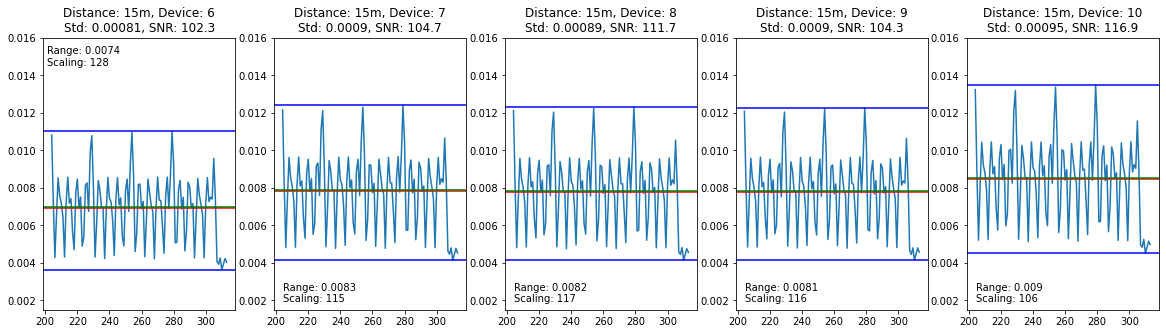

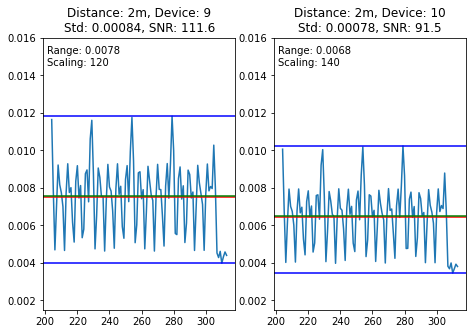

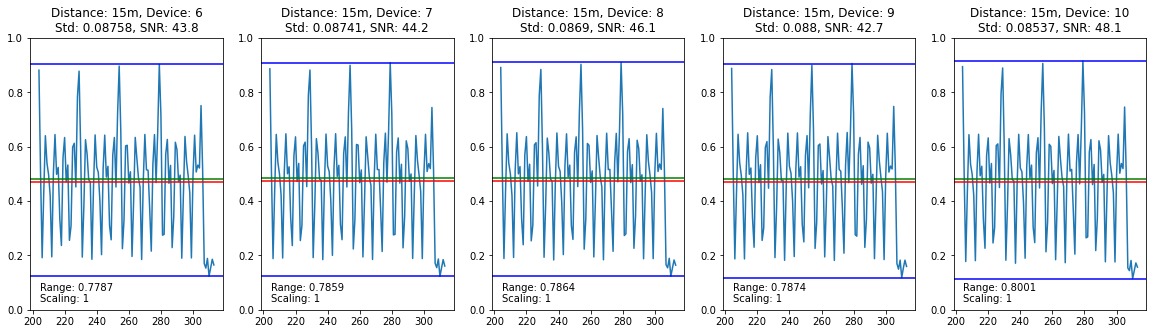

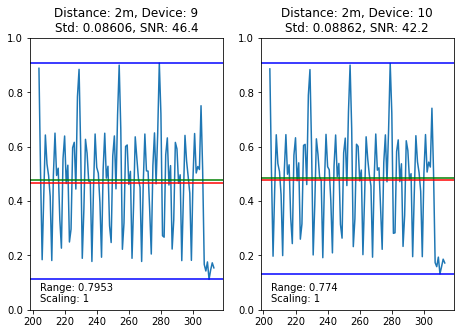

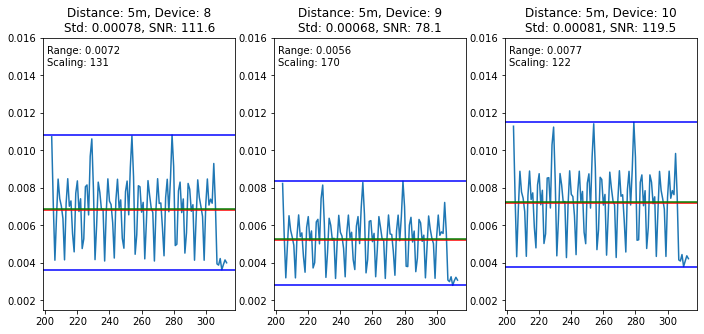

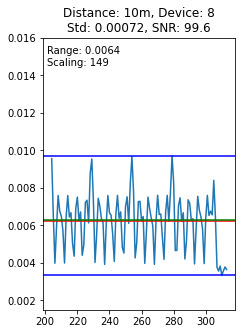

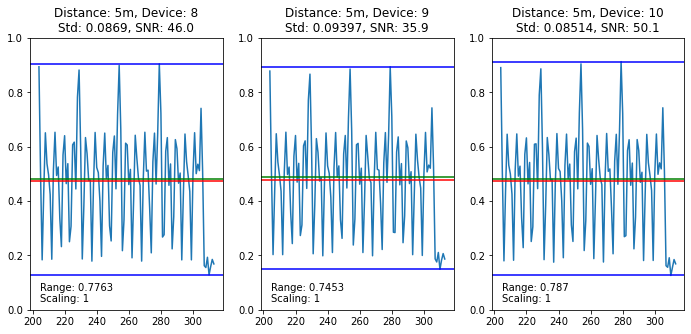

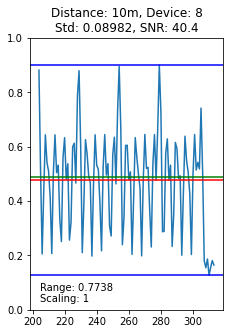

In [10]:
set1 = (1, [6, 7, 8, 9, 10], 15)
set2 = (2, [9, 10], 2)
#set3 = (2, [8, 9, 10], 5)
#set4 = (2, [8, 9, 10], 10)
sets = [set1, set2]#, set3, set4]

plot_test_trace_metadata_depth__several(sets, 2)
plot_test_trace_metadata_depth__several(sets, 3)

set2 = (2, [8, 9, 10], 5)
set4 = (2, [8], 10)
sets = [set2, set4]
plot_test_trace_metadata_depth__several(sets, 2, "5m.db")
plot_test_trace_metadata_depth__several(sets, 3, "5m.db")

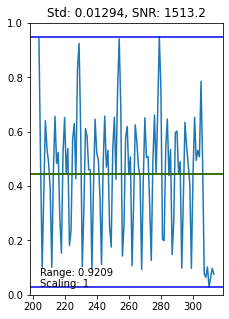

In [11]:
plot_training_trace_metadata_depth__training_set_used()

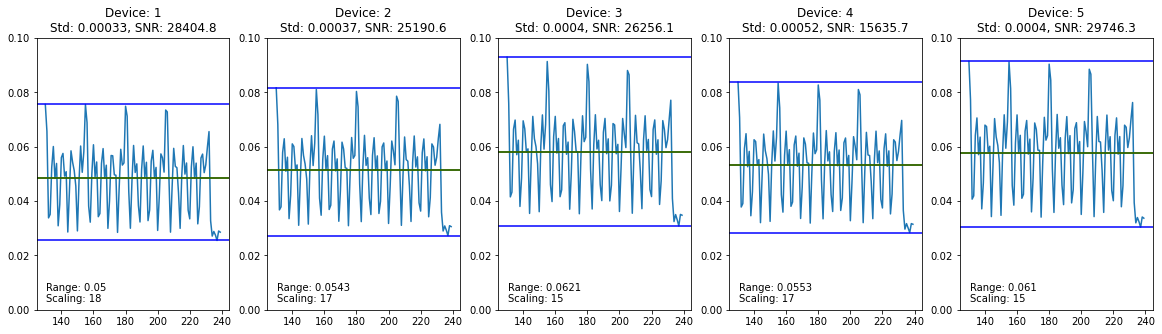

In [12]:
plot_training_trace_metadata_depth__several(130,240)